# Extract information from fitness landscape

In this notebook we look at the energy of the fitness landscape that we inferred. We also try to use this inferred landscape to design new proteins

In [1]:
import numpy as np
import torch


import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import pandas as pd
import seaborn as sns

from  scipy.spatial.distance import pdist, squareform 
from tqdm import tqdm


import config
import utils

from energy_py import EnergyFunctionCalculator, energy_calc_msa, energy_calc_single
import energy_py

from optimization import find_best_single_double_mutant

map_dict = utils.map_dict
WT = config.WT_AA_TENSOR.numpy()

## Inferred Landscape

Here we look at the energy distribution of sequenced data and random mutants under the inferred model

In [2]:
# Load parameters for inferred model

# model that includes main effect parameters
#model_prefix = "DHFR_incl_main_kit_taq"
model_prefix = "DHFR_incl_main_kit_taq_mse"

# model that has main effect parameters averaged out
#model_prefix = "DHFR_kit_taq"

h_i_a = torch.load(f"../working/{model_prefix}_h_i_a.pt").numpy()
e_i_a_j_b = torch.load(f"../working/{model_prefix}_e_i_a_j_b.pt").numpy()
#e_i_a_j_b = e_i_a_j_b / 2.

energy_calc = EnergyFunctionCalculator(h_i_a, e_i_a_j_b)

In [3]:
WT_energy = energy_calc(WT)
WT_energy

array(0.7909182)

In [4]:
@config.memory.cache
def get_aa_msa_from_codon_msa(filename):
    return config.get_aa_msa_from_codon_msa(filename)

msas = map_dict(lambda x: get_aa_msa_from_codon_msa(x).numpy().astype(np.uint8), 
                    config.MSA_FILESd)

In [5]:
def convert_energyd_to_dataframe(energyd, energy_type):
    dfs = []
    for k in energyd:
        df = pd.DataFrame({'energy':energyd[k]})
        df["round_num"] = k
        dfs.append(df)
        
    df = pd.concat(dfs)
    df["energy_type"] = energy_type
    return df


@config.memory.cache
def calc_all_energies(h_i_a, e_i_a_j_b):
    """ Calculate the energies of all the rounds"""
    msas = map_dict(get_aa_msa_from_codon_msa, config.MSA_FILESd)
    
    msa_energies_total = map_dict(
        lambda x: energy_calc_msa(x, h_i_a, e_i_a_j_b), msas )
    msa_energies_main = map_dict(
        lambda x: energy_calc_msa(x, h_i_a, np.zeros_like(e_i_a_j_b)), msas )
    msa_energies_int = map_dict(
        lambda x: energy_calc_msa(x, np.zeros_like(h_i_a), e_i_a_j_b), msas )

    all_energies = pd.concat(
        [convert_energyd_to_dataframe(energyd, energy_type) 
           for energyd, energy_type in [(msa_energies_total, "total"),
                                        (msa_energies_main, "main"),
                                        (msa_energies_int, "interaction")]])
    return all_energies

In [6]:
LOOKUPd = {a:[x for x in range(config.qa) if x != a] for a in range(config.qa)}

def mutate_prot(prot=WT, num_muts=1):
    mut = prot.copy()
    idxs_to_mut = np.random.choice(mut.shape[0], num_muts, replace=False)
    mutate_to = [np.random.choice(LOOKUPd[a]) for a in mut[idxs_to_mut]]
    mut[idxs_to_mut] = mutate_to
    return mut

def create_mut_msa(num_muts, num_prots):
    return np.array([mutate_prot(num_muts=num_muts) for _ in range(num_prots)])

def create_mut_msa_energy_array(num_muts, num_prots, h_i_a, e_i_a_j_b):
    msa = create_mut_msa(num_muts, num_prots)
    return energy_calc_msa(msa, h_i_a, e_i_a_j_b)

@config.memory.cache
def calc_mut_energies(num_muts_array, num_prots, h_i_a, e_i_a_j_b):
    dfs = []
    for num_muts in num_muts_array:
        e = create_mut_msa_energy_array(num_muts, num_prots=num_prots, 
                                        h_i_a=h_i_a, e_i_a_j_b=e_i_a_j_b)
        df = pd.DataFrame({"energy":e})
        df["num_muts"] = num_muts
        dfs.append(df)

    return pd.concat(dfs)    

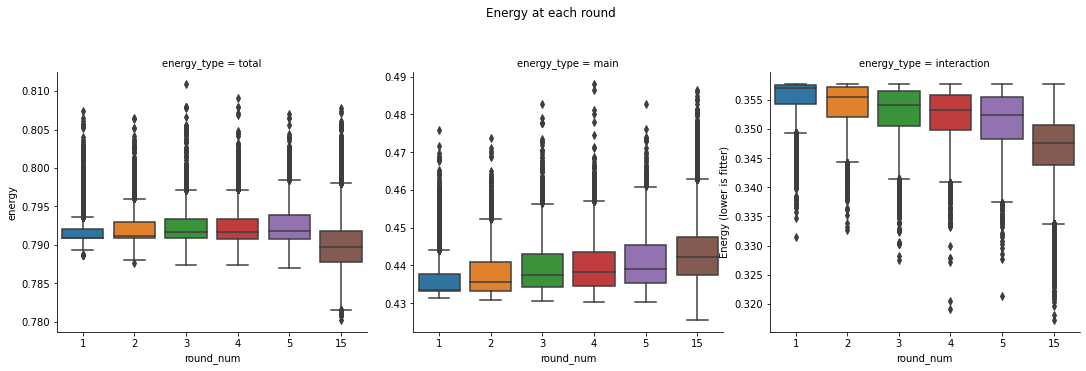

In [7]:
all_energies = calc_all_energies(h_i_a, e_i_a_j_b)

g = sns.catplot(x="round_num", y="energy", col="energy_type",
            kind="box", data=all_energies, sharey=False)
plt.ylabel("Energy (lower is fitter)")
plt.subplots_adjust(top=0.8)
plt.suptitle("Energy at each round")
pass

In [8]:
# Energy of fittest sequence
all_energies[all_energies.energy_type == "total"].energy.min() 

0.780199189973101

In [9]:
def dist_from_WT(s):
    return config.calc_min_dist(s, WT)

def dist_from_msa15(s):
    return config.calc_min_dist(s, msas[15])

msa15_energy = energy_calc(msas[15])

# Distance of fittest Round 15 sequence from WT
dist_from_WT(msas[15][msa15_energy.argmin(),])

15

In [10]:
# Count the residues where the maximum of the first order energy term 
# is different from that of WildType
(h_i_a.argmax(axis=1) != WT).sum()

41

In [11]:
mut_energies_short = calc_mut_energies(range(1, 6), 1000, 
                                 h_i_a = h_i_a, e_i_a_j_b=e_i_a_j_b)

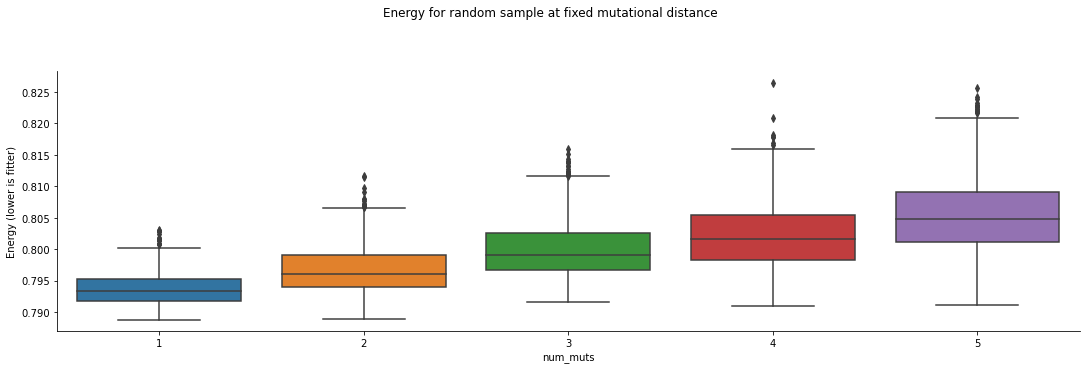

In [12]:
g = sns.catplot(x="num_muts", y="energy",
            kind="box", data=mut_energies_short, aspect=3)
plt.subplots_adjust(top=0.8)
plt.ylabel("Energy (lower is fitter)")
plt.suptitle("Energy for random sample at fixed mutational distance")
pass

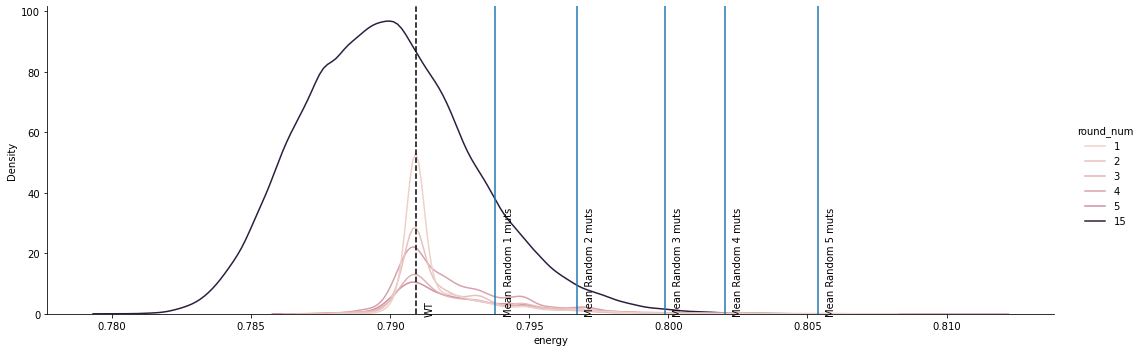

In [13]:
mut_energies_short_mean = mut_energies_short.groupby("num_muts").energy.mean().reset_index()

g = sns.displot(x="energy", hue="round_num",
            kind="kde", data=all_energies[all_energies.energy_type == "total"],
               aspect=3)
plt.axvline(WT_energy, linestyle="--", color="black")
plt.text(WT_energy + 0.0003, 0, 'WT',rotation=90)

for idx, row in mut_energies_short_mean.iterrows():
    plt.axvline(row.energy)
    plt.text(row.energy + 0.0003, 0, f'Mean Random {int(row.num_muts)} muts',rotation=90)

pass

In [14]:
mut_energies = calc_mut_energies(range(6, 187, 6), 1000, 
                                 h_i_a = h_i_a, e_i_a_j_b=e_i_a_j_b)

In [15]:
mut_energies[mut_energies.num_muts == 12].energy.mean()

0.8266470121027757

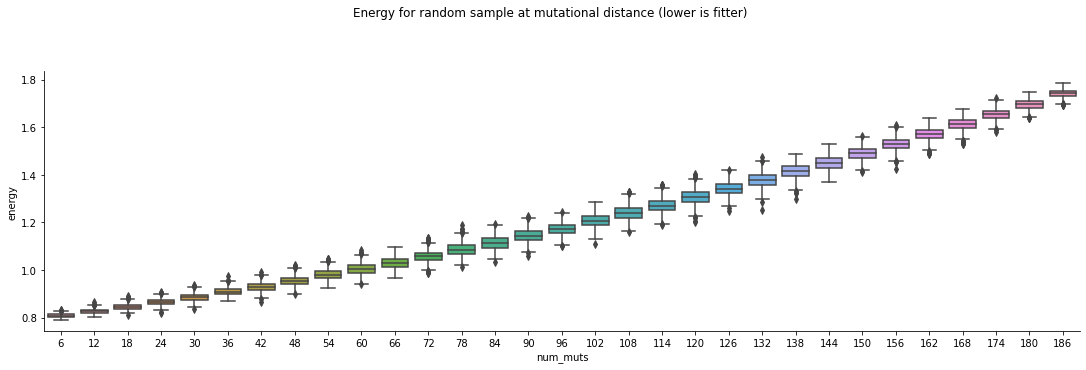

In [16]:
g = sns.catplot(x="num_muts", y="energy",
            kind="box", data=mut_energies, aspect=3)
plt.subplots_adjust(top=0.8)
plt.suptitle("Energy for random sample at mutational distance (lower is fitter)")
pass

## Natural Landscape (Potts Model on Natural seqs)

Here we look at the energy distribution of sequenced data and random mutants under the Potts model on natural sequences in the evolutionary record.

In [17]:
natural_params_dir = "../DHFR/uniprot/bmDCA"
natural_prefix = "DHFR_bmdca_"
natural_h_i_a = np.load(f"{natural_params_dir}/{natural_prefix}h_i_a.npy")
natural_e_i_a_j_b = np.load(f"{natural_params_dir}/{natural_prefix}e_i_j_a_b.npy")

natural_energy = EnergyFunctionCalculator(natural_h_i_a, natural_e_i_a_j_b)
natural_WT_energy = natural_energy(WT)
natural_WT_energy

array(-507.21376961)

In [18]:
@config.memory.cache
def get_natural_sequences_energy(natural_msa_filename, energy_calculator):
    natural_msa = config.get_aa_msa_as_int_array(natural_msa_filename, as_torch=False)
    return energy_calculator(natural_msa)

natural_msa_energy = get_natural_sequences_energy(
    natural_msa_filename = "../DHFR/uniprot/bmDCA/DHFR_msa.txt.gz",
    energy_calculator = natural_energy)


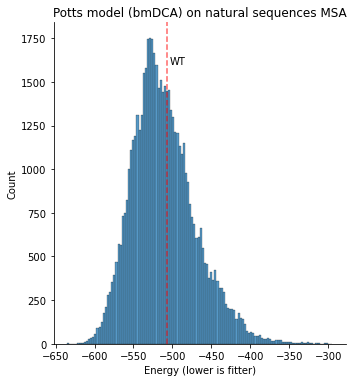

In [19]:
g = sns.displot(natural_msa_energy)
ax = plt.gca()
ax.set_title("Potts model (bmDCA) on natural sequences MSA")
ax.set_xlabel("Energy (lower is fitter)")
ax.axvline(natural_WT_energy, linestyle="--", color="red", alpha=0.6)
plt.text(natural_WT_energy + 3, 1600,'WT',rotation=0)
pass

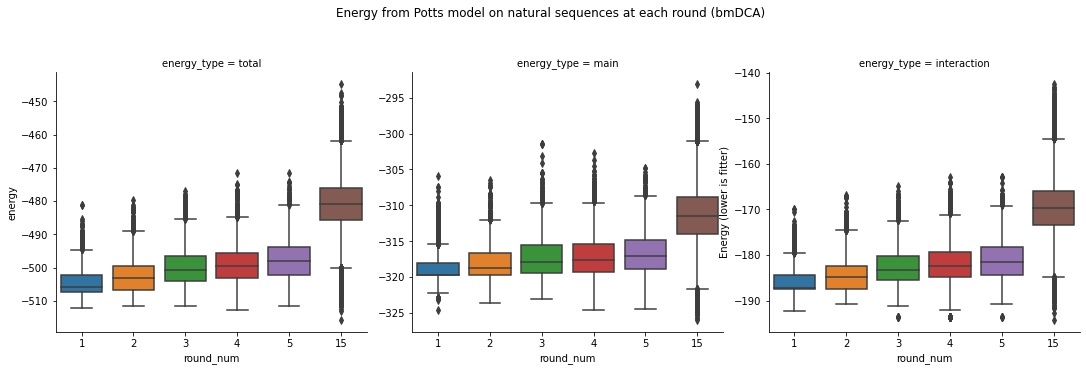

In [20]:
natural_all_energies = calc_all_energies(natural_energy.h_i_a, natural_energy.e_i_a_j_b)
g = sns.catplot(x="round_num", y="energy", col="energy_type",
            kind="box", data=natural_all_energies, sharey=False)
plt.ylabel("Energy (lower is fitter)")
plt.subplots_adjust(top=0.8)
plt.suptitle("Energy from Potts model on natural sequences at each round (bmDCA)")
pass

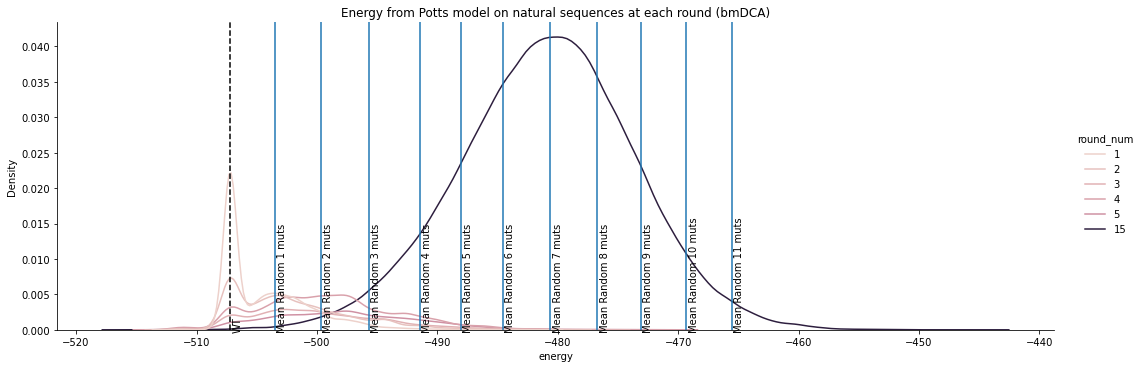

In [21]:
natural_energies_short = calc_mut_energies(range(1, 30), 1000, 
                                 natural_energy.h_i_a, natural_energy.e_i_a_j_b)

natural_energies_short_mean = natural_energies_short.groupby("num_muts").energy.mean().reset_index()

g = sns.displot(x="energy", hue="round_num",
            kind="kde", data=natural_all_energies[natural_all_energies.energy_type == "total"],
               aspect=3)
plt.axvline(natural_WT_energy, linestyle="--", color="black")
plt.text(natural_WT_energy + 0.2, 0, 'WT',rotation=90)
plt.title("Energy from Potts model on natural sequences at each round (bmDCA)")

for idx, row in natural_energies_short_mean.iterrows():
    if row.num_muts > 11:
        continue
    plt.axvline(row.energy)
    plt.text(row.energy + 0.2, 0, f'Mean Random {int(row.num_muts)} muts',rotation=90)

pass

## Design new sequences starting from most common sequence

We start with the most common sequence in Round 15 and then we search for the fittest single or double mutant that does not make have substitutions towards WT. Then we take this fit sequences and again search for the its fittest single or double mutant that does not have back substitutions towards WT. We iterate this till the process stops.

In [22]:
msa15_unique, msa15_counts = np.unique(msas[15], axis=0, return_counts=True)
most_common_sequence = msa15_unique[msa15_counts.argmax()]
msa15_counts.max() # count of the most common sequence

13

In [23]:
def str_prot_diff(s1, s2):
    idxs = np.where(s1 != s2)[0]
    return(f"{idxs}: {config.prot_to_string(s1[idxs])} -> "
          f"{config.prot_to_string(s2[idxs])}")



In [24]:
def calc_seq_info(seq, prev_seq=None, round_num=0):
    ret = {}
    ret['seq'] = config.prot_to_string(seq)
    ret['seq_numpy'] = seq
    ret['round_num'] = round_num
    ret['energy'] = energy_calc(seq).item()
    ret['natural_energy'] = natural_energy(seq).item()
    ret['dist_WT'] = dist_from_WT(seq)
    ret['dist_common'] = config.calc_min_dist(seq, most_common_sequence)
    ret['dist_msa15'] = dist_from_msa15(seq)
    ret['dist_prev'] = 0
    if prev_seq is not None:
        ret['dist_prev'] = config.calc_min_dist(seq, prev_seq)
    return ret


In [25]:
min_seq = most_common_sequence
min_energy = energy_calc_single(min_seq, h_i_a, e_i_a_j_b)

designed_proteins = []

design = {}

seq_info = calc_seq_info(most_common_sequence)

print(f"Starting with most common sequence")
designed_proteins.append(seq_info)

print(f"Starting  Round {seq_info['round_num']}: "
      f"Distance from WT : {seq_info['dist_WT']}, "
      f"energy : {min_energy:.4f}")
print("Difference from WT", str_prot_diff(most_common_sequence, WT))
print()
min_seqs = [min_seq]
min_energies = [min_energy]
for i in range(38):
    min_seq, min_energy = find_best_single_double_mutant(min_seq, h_i_a, e_i_a_j_b)
    seq_info = calc_seq_info(min_seq, prev_seq=designed_proteins[-1]['seq_numpy'], round_num=i+1)
    print(f"-----------------------")
    print(f"In silico round {seq_info['round_num']}:")
    print(f"-----------------------")

    #print(config.prot_to_string(min_seq))
    print(f"Distance from WT : {seq_info['dist_WT']}, "
          f"Distance from prev : {seq_info['dist_prev']}, "
          f"Distance from msa15: {seq_info['dist_msa15']}, ")
    print(f"energy : {seq_info['energy']:.4f}, natural_energy : {seq_info['natural_energy']:.2f}" )
    print("  :-> Prev difference", str_prot_diff(designed_proteins[-1]['seq_numpy'], min_seq))
    print("  :-> WT difference", str_prot_diff(WT, min_seq))
    print()

    designed_proteins.append(seq_info)


Starting with most common sequence
Starting  Round 0: Distance from WT : 10, energy : 0.7863
Difference from WT [ 18  40  79  94 141 143 144 165 179 185]: DGIGLCNPAV -> NSKDFSDLED

-----------------------
In silico round 1:
-----------------------
Distance from WT : 12, Distance from prev : 2, Distance from msa15: 2, 
energy : 0.7816, natural_energy : -479.71
  :-> Prev difference [ 16 102]: GP -> AN
  :-> WT difference [ 16  18  40  79  94 102 141 143 144 165 179 185]: GNSKDPFSDLED -> ADGIGNLCNPAV

-----------------------
In silico round 2:
-----------------------
Distance from WT : 14, Distance from prev : 2, Distance from msa15: 4, 
energy : 0.7790, natural_energy : -470.46
  :-> Prev difference [ 53 131]: RR -> HM
  :-> WT difference [ 16  18  40  53  79  94 102 131 141 143 144 165 179 185]: GNSRKDPRFSDLED -> ADGHIGNMLCNPAV

-----------------------
In silico round 3:
-----------------------
Distance from WT : 16, Distance from prev : 2, Distance from msa15: 6, 
energy : 0.7769, nat

-----------------------
In silico round 20:
-----------------------
Distance from WT : 47, Distance from prev : 2, Distance from msa15: 35, 
energy : 0.7595, natural_energy : -410.26
  :-> Prev difference [114 172]: VK -> IE
  :-> WT difference [  0  16  18  27  34  39  40  48  51  53  54  57  62  68  77  79  83  84
  94  97 102 105 107 108 114 119 121 126 127 130 131 139 141 142 143 144
 153 154 156 159 165 167 172 179 182 184 185]: VGNRQTSLMRKFKDEKRGDRPAKVVVQQPLRQFESDGKKPLEKEEKD -> CAEHRICIIHNCEGKIICGQNSRAICRRHVMHCKCNSIIHPGEAVRV

-----------------------
In silico round 21:
-----------------------
Distance from WT : 49, Distance from prev : 2, Distance from msa15: 37, 
energy : 0.7591, natural_energy : -407.03
  :-> Prev difference [124 177]: MK -> IR
  :-> WT difference [  0  16  18  27  34  39  40  48  51  53  54  57  62  68  77  79  83  84
  94  97 102 105 107 108 114 119 121 124 126 127 130 131 139 141 142 143
 144 153 154 156 159 165 167 172 177 179 182 184 185]: VGNRQTSLMRKFKDEK

-----------------------
In silico round 34:
-----------------------
Distance from WT : 72, Distance from prev : 2, Distance from msa15: 58, 
energy : 0.7558, natural_energy : -374.95
  :-> Prev difference [129 160]: HE -> RK
  :-> WT difference [  0  11  12  16  17  18  20  27  30  32  34  38  39  40  42  45  48  51
  53  54  57  62  63  67  68  70  76  77  79  83  84  91  94  97  99 102
 105 106 107 108 110 114 117 119 121 124 125 126 127 129 130 131 139 141
 142 143 144 152 153 154 156 159 160 165 167 172 175 177 179 182 184 185]: VQNGKNDRFYQTTSVKLMRKFKNKDIREKRGSDRIPASKVMVSVQMNQPHLRQFESDLGKKPELEKKKEEKD -> CRDANEGHLHRAICARIIHNCESRGVHKEQCGGQVNSPRAKIRARIDRHRVMHCKCNSSIIHKPGERRAVRV

-----------------------
In silico round 35:
-----------------------
Distance from WT : 74, Distance from prev : 2, Distance from msa15: 59, 
energy : 0.7557, natural_energy : -373.98
  :-> Prev difference [ 28 101]: NQ -> SR
  :-> WT difference [  0  11  12  16  17  18  20  27  28  30  32  34  38  39  40  42  

In [26]:
designed_proteins = pd.DataFrame(designed_proteins)
designed_proteins = designed_proteins.drop(columns=["seq_numpy"])
designed_proteins

,seq,round_num,energy,natural_energy,dist_WT,dist_common,dist_msa15,dist_prev
0,VRPLNCIVAVSQNMGIGKDGDLPWPPLRNEFKYFQRMTTTGSVEGK...,0,0.786270,-490.657739,10,0,0,0
1,VRPLNCIVAVSQNMGIAKDGDLPWPPLRNEFKYFQRMTTTGSVEGK...,1,0.781615,-479.709964,12,2,2,2
2,VRPLNCIVAVSQNMGIAKDGDLPWPPLRNEFKYFQRMTTTGSVEGK...,2,0.778994,-470.462492,14,4,4,2
3,VRPLNCIVAVSQNMGIAKDGDLPWPPLRNEFKYFQRMTTTGSVEGK...,3,0.776915,-460.427448,16,6,6,2
4,VRPLNCIVAVSQNMGIAKDGDLPWPPLRNEFKYFQRMTTTGSVEGK...,4,0.775064,-456.275702,18,8,8,2
5,VRPLNCIVAVSQNMGIAKDGDLPWPPLRNEFKYFQRMTTTGSVEGK...,5,0.773416,-446.113990,20,10,10,2
6,VRPLNCIVAVSQNMGIAKDGDLPWPPLRNEFKYFQRMTTIGSVEGK...,6,0.771807,-439.838341,22,12,12,2
7,VRPLNCIVAVSQNMGIAKDGDLPWPPLRNEFKYFQRMTTIGSVEGK...,7,0.770479,-441.243086,23,14,14,2
8,VRPLNCIVAVSQNMGIAKDGDLPWPPLRNEFKYFQRMTTIGSVEGK...,8,0.769250,-440.732868,25,16,16,2
9,VRPLNCIVAVSQNMGIAKDGDLPWPPLRNEFKYFQRMTTIGSVEGK...,9,0.768139,-442.572899,27,18,18,2


In [27]:
designed_proteins.to_csv(f"{config.WORKING_DIR}/{model_prefix}_designed.csv", index=False)

In [28]:
order_mask = designed_proteins['round_num'].isin([1,2,3,4,5,7,9,11,13,15])
designed_proteins.loc[order_mask].to_csv(
    f"{config.WORKING_DIR}/{model_prefix}_designed_order.csv", index=False)

In [29]:
designed_proteins_melt = pd.melt(designed_proteins.drop(columns=["seq"]), id_vars="round_num")

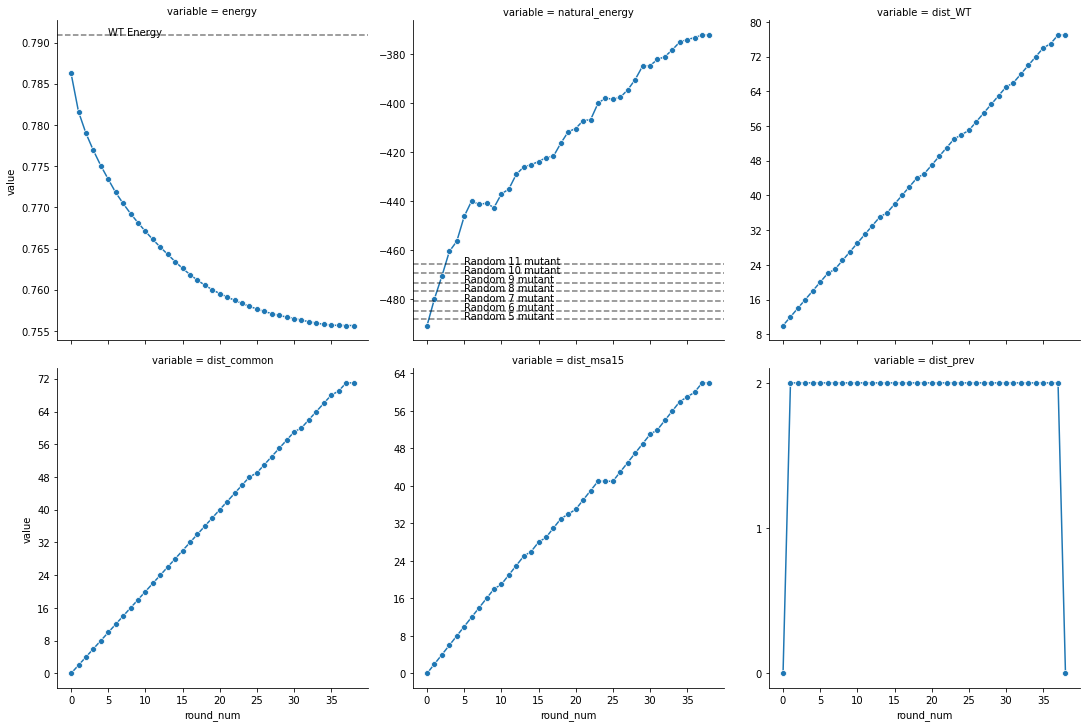

In [30]:
g = sns.relplot(x="round_num", y="value", kind="line", col="variable", marker="o", col_wrap=3, 
            facet_kws={"sharey":False}, data=designed_proteins_melt)

for key, ax in g.axes_dict.items():
    variable = key
    if variable == "energy":
        ax.axhline(WT_energy, linestyle="--", alpha=0.5, color="black")
        ax.text(5, WT_energy, f"WT Energy")
    if variable == "natural_energy":
        num_muts_mask = (natural_energies_short_mean.num_muts > 4) & \
                            (natural_energies_short_mean.num_muts < 12)
        for idx, row in natural_energies_short_mean[num_muts_mask].iterrows():
            ax.axhline(row.energy, linestyle="--", alpha=0.5, color="black")
            ax.text(5, row.energy, f"Random {int(row.num_muts)} mutant")
    if variable[:5] == "dist_":
        ax.get_yaxis().set_major_locator(MaxNLocator(integer=True))
        
pass

In [31]:
designed_proteins.iloc[-1]

seq               AQPLNCIVAVSRDMGIANEGGLPWPPLHSELRHFRRMTAICSAEGR...
round_num                                                        38
energy                                                      0.75566
natural_energy                                              -372.11
dist_WT                                                          77
dist_common                                                      71
dist_msa15                                                       62
dist_prev                                                         0
Name: 38, dtype: object

In [32]:
mut = np.array([config.AA_MAP[s] for s in designed_proteins.iloc[-1].seq])
energy_calc(mut)

array(0.7556596)